Perez Bikes Prediction Application 

In [1]:
import pandas as pd
import numpy as np
import os
import psycopg2 as ps
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
from datetime import datetime
import sqlalchemy as sqla

In [2]:
orders_table = pd.read_csv('orders_updated.csv')
bikes_table = pd.read_csv('bikes.csv')
orders_table.head()

,order.id,order.date,customer.id,product.id,quantity
0,1,1/7/2011,2,48,1
1,1,1/7/2011,2,52,1
2,2,1/10/2011,10,76,1
3,2,1/10/2011,10,52,1
4,3,1/10/2011,6,2,1


In [3]:
bikes_table.head()

,bike.id,model
0,1,Supersix Evo Black Inc.
1,2,Supersix Evo Hi-Mod Team
2,3,Supersix Evo Hi-Mod Dura Ace 1
3,4,Supersix Evo Hi-Mod Dura Ace 2
4,5,Supersix Evo Hi-Mod Utegra


In [4]:
orders_table.drop(['customer.id'], axis = 1)
orders_table.head()

,order.id,order.date,customer.id,product.id,quantity
0,1,1/7/2011,2,48,1
1,1,1/7/2011,2,52,1
2,2,1/10/2011,10,76,1
3,2,1/10/2011,10,52,1
4,3,1/10/2011,6,2,1


In [5]:
# create prediction table by merging orders table and bike table on bike id = product id 
pred = pd.merge(orders_table, bikes_table, left_on="product.id", right_on="bike.id")
pred

,order.id,order.date,customer.id,product.id,quantity,bike.id,model
0,1,1/7/2011,2,48,1,48,Jekyll Carbon 2
1,23,2/4/2011,8,48,1,48,Jekyll Carbon 2
2,44,2/28/2011,16,48,1,48,Jekyll Carbon 2
3,48,3/3/2011,30,48,1,48,Jekyll Carbon 2
4,66,3/23/2011,6,48,1,48,Jekyll Carbon 2
...,...,...,...,...,...,...,...
15639,1894,9/8/2015,4,59,1,59,Scalpel-Si Carbon 3
15640,1915,9/25/2015,10,59,1,59,Scalpel-Si Carbon 3
15641,1938,10/29/2015,10,59,1,59,Scalpel-Si Carbon 3
15642,1986,12/17/2015,28,59,1,59,Scalpel-Si Carbon 3


In [6]:
# add a column to the pred table that contains the week of the year and year of the order 
pred["order.date"] = pd.to_datetime(pred["order.date"])
pred['year_week'] = pred['order.date'].dt.isocalendar().week
pred['year'] = pred['order.date'].dt.isocalendar().year
pred

,order.id,order.date,customer.id,product.id,quantity,bike.id,model,year_week,year
0,1,2011-01-07,2,48,1,48,Jekyll Carbon 2,1,2011
1,23,2011-02-04,8,48,1,48,Jekyll Carbon 2,5,2011
2,44,2011-02-28,16,48,1,48,Jekyll Carbon 2,9,2011
3,48,2011-03-03,30,48,1,48,Jekyll Carbon 2,9,2011
4,66,2011-03-23,6,48,1,48,Jekyll Carbon 2,12,2011
...,...,...,...,...,...,...,...,...,...
15639,1894,2015-09-08,4,59,1,59,Scalpel-Si Carbon 3,37,2015
15640,1915,2015-09-25,10,59,1,59,Scalpel-Si Carbon 3,39,2015
15641,1938,2015-10-29,10,59,1,59,Scalpel-Si Carbon 3,44,2015
15642,1986,2015-12-17,28,59,1,59,Scalpel-Si Carbon 3,51,2015


In [7]:
b_day = orders_table[['order.date','quantity']]
b_day

,order.date,quantity
0,1/7/2011,1
1,1/7/2011,1
2,1/10/2011,1
3,1/10/2011,1
4,1/10/2011,1
...,...,...
15639,12/25/2015,1
15640,12/25/2015,1
15641,12/25/2015,1
15642,12/25/2015,1


In [8]:
b_per_day = b_day.groupby('order.date')['quantity'].sum()

In [9]:
b_per_day

order.date
1/1/2013     26
1/1/2014      4
1/1/2015      5
1/10/2011     7
1/11/2011    10
             ..
9/8/2014      1
9/8/2015     29
9/9/2011      2
9/9/2014     35
9/9/2015     13
Name: quantity, Length: 962, dtype: int64

In [19]:
b_per_day.dtype

dtype('int64')

In [10]:
bPD = b_per_day.to_frame()
bPD

,quantity
order.date,
1/1/2013,26
1/1/2014,4
1/1/2015,5
1/10/2011,7
1/11/2011,10
...,...
9/8/2014,1
9/8/2015,29
9/9/2011,2


In [17]:
bPD['order.date'].dtype

dtype('<M8[ns]')

In [16]:
bPD['order_date'] = pd.to_datetime(bPD.iloc[:,0], format='%m/%dd/%Y')
bPD['year_week'] = bPD['order.date'].dt.isocalendar().week
bPD['year'] = bPD['order.date'].dt.isocalendar().year
bPD

ValueError: time data '26' does not match format '%m/%dd/%Y' (match)

In [14]:
b_day.groupby(['order.date', 'year', 'year_week'])['quantity'].sum()
b_day

KeyError: 'year'

In [12]:
b_per_day = b_day[['order.date', 'quantity', 'year_week', 'year']].copy()
b_per_day

,order.date,quantity,year_week,year
0,2011-01-07,1,1,2011
1,2011-01-07,1,1,2011
2,2011-01-10,1,2,2011
3,2011-01-10,1,2,2011
4,2011-01-10,1,2,2011
...,...,...,...,...
15639,2015-12-25,1,52,2015
15640,2015-12-25,1,52,2015
15641,2015-12-25,1,52,2015
15642,2015-12-25,1,52,2015


In [23]:
b_per_day = b_per_day.groupby(['order.date','year_week', 'year'])['quantity'].sum()
b_per_day

KeyError: 'order.date'

In [14]:
type(b_per_day)

pandas.core.series.Series

In [15]:
b_per_day = pd.DataFrame([b_per_day])

In [16]:
b_per_day

order.date,2011-01-07,2011-01-10,2011-01-11,2011-01-12,2011-01-17,2011-01-18,2011-01-20,2011-01-24,2011-01-25,2011-01-26,...,2015-12-04,2015-12-09,2015-12-10,2015-12-16,2015-12-17,2015-12-18,2015-12-22,2015-12-23,2015-12-24,2015-12-25
year_week,1,2,2,2,3,3,3,4,4,4,...,49,50,50,51,51,51,52,52,52,52
year,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015
quantity,2,7,10,20,11,8,24,3,28,1,...,32,27,20,19,49,2,26,37,1,8


In [ ]:
b_per_day = b_per_day.pivot(index="order.date", columns="")

In [17]:
import ipywidgets as w    

In [18]:
from ipywidgets import interact

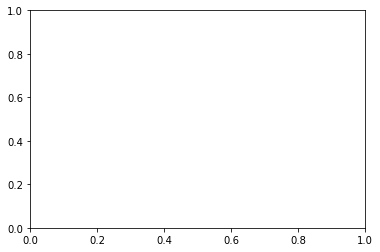

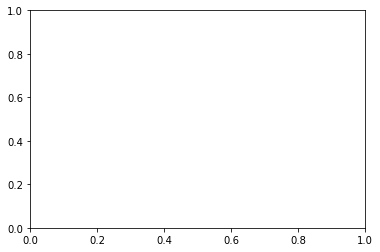

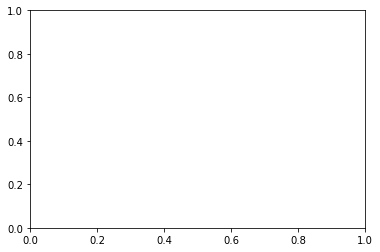

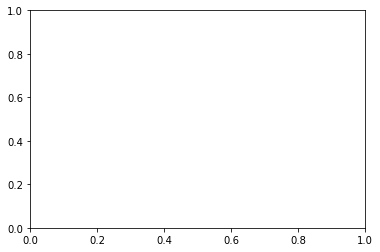

In [19]:
# create a tab menu for ts graphs 
%matplotlib inline
from IPython.display import clear_output
 
# output variables
op11 = w.Output()
op12 = w.Output()
op13 = w.Output()
op14 = w.Output()
op15 = w.Output()


# tab setup 
tab = w.Tab(children = [op11, op12, op13, op14, op15])
tab.set_title(0,'2011')
tab.set_title(1, '2012')
tab.set_title(2, '2013')
tab.set_title(3, '2014')
tab.set_title(4, '2015')
display(tab)

# output commands 
with op11:
    clear_output(wait=True)
    fig1, ax1 = plt.subplots()
    ts_2011 = b_per_day.loc[(b_per_day['year'] == 2011)]
    ts2011_plot = ax1.plot(ts_2011['year_week'], ts_2011['quantity'])
    plt.title('2011')
    ax1.set_ylabel('Quantity')
    ax1.set_xlabel('Week')
    plt.show(fig1)
    
with op12:
    fig1, ax2 = plt.subplots()
    ts_2012 = b_per_day.loc[(b_per_day['year'] == 2012)]
    ts_2012_plot = ax2.plot(ts_2012['year_week'], ts_2012['quantity'])
    plt.title('2012')
    ax2.set_ylabel('Quantity')
    ax2.set_xlabel('Week')
    plt.show(fig1)

    
with op13:
    fig1, ax3 = plt.subplots()
    ts_2013 = b_per_day.loc[(b_per_day['year'] == 2013)]
    ts_2013_plot = ax3.plot(ts_2013['year_week'], ts_2013['quantity'])
    plt.title('2013')
    ax3.set_ylabel('Quantity')
    ax3.set_xlabel('Week')
    plt.show(fig1)
    
with op14:
    fig4, ax4 = plt.subplots()
    ts_2014 = b_per_day.loc[(b_per_day['year'] == 2014)]
    ts_2014_plot = ax4.plot(ts_2014['year_week'], ts_2014['quantity'])
    plt.title('2014')
    ax4.set_ylabel('Quantity')
    ax4.set_xlabel('Week')
    plt.show(fig4)

with op15:
    fig5, ax5 = plt.subplots()
    ts_2015 = b_per_day.loc[(b_per_day['year'] == 2015)]
    ts_2015_plot = ax5.plot(ts_2015['year_week'], ts_2015['quantity'])
    plt.title('2015')
    ax5.set_ylabel('Quantity')
    ax5.set_xlabel('Week')
    plt.show(fig5)
    
    

# close all figures
plt.close()

In [20]:
# XY scatter plot (x: customer id, y: number of bikes per transaction)
xy_table = pd.read_sql_query('''SELECT customer_id, COUNT(quantity) FROM orders_updated GROUP BY customer_id;''', connection)

NameError: name 'connection' is not defined

In [ ]:
xy_table.plot.scatter(x='customer_id', y='count')

In [ ]:
# bar graph (y: the amount of that bike sold that week, x: model name of bike)
# [bike.id should be transformed here to make it easier to read]
bar_graph = pd.read_sql_query('''SELECT model, order_date, quantity FROM prediction''', connection)
bar_graph['order_date'] = pd.to_datetime(bar_graph["order_date"])
bar_graph['year_week'] = bar_graph['order_date'].dt.isocalendar().week
bar_graph['year'] = bar_graph['order_date'].dt.isocalendar().year
bar_graph.groupby(['year','model']).count()
bg_update=bar_graph.drop(columns=['order_date', 'year_week'], axis = 1)
bg_pivot = bg_update.pivot_table(index='model', columns= 'year', values='quantity', aggfunc='sum')
bg_pivot.plot.barh(figsize=(16,20))
plt.yticks(fontsize=10, rotation=30)
plt.legend(bbox_to_anchor=(0.5,1))

In [ ]:
# linear regression algorithm 
# args should be two dates: following monday and next saturday
# function should return an array: [bike 1's name : quantity; b2 : q; b3 : q]
import xgboost as xgb

In [ ]:
import sklearn

In [ ]:
# cleaning data to prep for algorithm
xgb_table = pred.drop(['order_id', 'order_date'], axis=1)

In [ ]:
xgb_table = xgb_table[['product_id', 'model', 'quantity', 'year_week', 'year']]
xgb_table

In [ ]:
# sorting the above table 
xgb_groupby = xgb_table.groupby(['year', 'year_week', 'product_id']).sum().reset_index()
xgb_groupby

In [ ]:
X = xgb_groupby['product_id']
y = xgb_groupby['quantity']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
import numpy as np

In [ ]:
# convert X_train to a 2D array 
X_train.to_numpy()
X_train

In [ ]:
X_train = np.array(X_train).reshape(-1,1)

In [ ]:
# converting X_test to a 2D array 
X_test.to_numpy()
X_test = np.array(X_test).reshape(-1,1)

In [ ]:
# linear regression method
lr = LinearRegression()
lr.fit(X_train, y_train)
Y_pred= lr.predict(X_test)

In [ ]:
from sklearn import metrics

In [ ]:
print("MAE: ", metrics.mean_absolute_error(y_test, Y_pred))
print("MSE: ", metrics.mean_squared_error(y_test, Y_pred))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, Y_pred)))

In [ ]:
# XGBoost method 
xgb_regressor = xgb.XGBRegressor(booster = 'gblinear')
xgb_regressor.fit(X_train, y_train)

In [ ]:
xgb_pred = xgb_regressor.predict(X_test)

In [ ]:
print("RSME: ", np.sqrt(metrics.mean_squared_error(y_test, xgb_pred)))

In [ ]:
# print array of predicted values
xgb_pred

In [ ]:
# convert X_test into a 1D array
new_X_test = X_test.reshape(-1)
new_X_test

In [ ]:
# combine X_test and xgb_pred into one array to get predicted values for each bike 
verification = np.stack((new_X_test, xgb_pred), axis=1)
verification

In [ ]:
# convert verification array to dataframe 
verif_df = pd.DataFrame(verification, columns = ['Bike ID', "Quantity"])
verif_df.set_index('Bike ID')
verif_df

In [ ]:
# sort verif_df by desc quantities
sorted_verif = verif_df.sort_values(by=['Quantity'], ascending=False)
sorted_verif

In [ ]:
sorted_verif.groupby('Bike ID')['Quantity'].sum()
sorted_verif

In [ ]:
# trying to get above function to do what I want without messing it up further 
test_df = sorted_verif.groupby('Bike ID').sum()
test_df

In [ ]:
# using test_df since that currently shows what I want it to 
highest_df = test_df.sort_values('Quantity', ascending = False)
highest_df.head()

In [ ]:
# create a new datafram based on model names to merge with the highest_df above 
model_df = pd.read_sql_query('''SELECT bike, model FROM BIKES''', connection)
model_df

In [ ]:
# renaming product id column:
model_df.rename(columns={'bike': 'Bike ID'}, inplace = True)
model_df.head()

In [ ]:
# merging model_df and highest_df
return_df = pd.merge(highest_df, model_df, on=['Bike ID', 'Bike ID'])
return_df